## Chatbot

In [8]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
import pandas as pd
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential



In [4]:
import re
import json
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd

with open('dataset3.json') as f:
    data = json.load(f)

# Load the additional corpus from corpus.json
with open('dataset2.json') as f:
    corpus_data = json.load(f)

# Append the corpus data to the existing data
data['intents'].extend(corpus_data)

stop_words = set()

with open('stopword_id.txt', 'r', encoding='utf-8') as file:
    for line in file:
        stop_words.add(line.strip())

tags = []
inputs = []
responses = {}
lemmatizer = WordNetLemmatizer()

for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for line in intent['patterns']:
        # Prapemrosesan teks
        line = re.sub('[^a-zA-Z0-9\s]', '', line)
        line = re.sub(r'[.,’"\'-?:!;]', '', line)
        line = re.sub(r'^Apa|^Saya|^Aku|^maukah|^Siapa|^Bagaimana|^Dimana|^Kapan|^Kenapa|^Bisakah', '', line)
        
        # Tokenize each word in the pattern
        w = nltk.word_tokenize(line)
        w = [lemmatizer.lemmatize(word.lower()) for word in w if word not in stop_words]
        inputs.append(' '.join(w))
        tags.append(intent['tag'])

# Create a DataFrame
data_df = pd.DataFrame({"inputs": inputs, "tags": tags})


In [5]:
print(data_df)

                                              inputs  \
0                              pengertian menstruasi   
1                                         menstruasi   
2                                               haid   
3                                         menstruasi   
4                                         menstruasi   
...                                              ...   
1012        mengatasi polycystic ovary syndrome pcos   
1013  kah polycystic ovary syndrome pcos disembuhkan   
1014                              menstruasi teratur   
1015                  menyebabkan menstruasi teratur   
1016                    mengatasi menstruasi teratur   

                                            tags  
0                          pengertian_menstruasi  
1                          pengertian_menstruasi  
2                          pengertian_menstruasi  
3                          pengertian_menstruasi  
4                          pengertian_menstruasi  
...                  

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Tokenizer
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(data_df['inputs'])

# Encode the outputs
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(data_df['tags'])

# Define input shape
input_shape = 100  # Misalkan panjang maksimum input adalah 100 kata

# Padding sequences
sequences = tokenizer.texts_to_sequences(data_df['inputs'])
x_train = pad_sequences(sequences, maxlen=input_shape, truncating='post')

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [9]:
model = Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 64, input_length=100),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax'),
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [10]:
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/200
26/26 [==============================] - 5s 120ms/step - loss: 5.7705 - accuracy: 0.0049 - val_loss: 5.7574 - val_accuracy: 0.0000e+00
Epoch 2/200
26/26 [==============================] - 3s 100ms/step - loss: 5.7355 - accuracy: 0.0086 - val_loss: 5.9085 - val_accuracy: 0.0147
Epoch 3/200
26/26 [==============================] - 3s 106ms/step - loss: 5.7075 - accuracy: 0.0098 - val_loss: 5.9792 - val_accuracy: 0.0147
Epoch 4/200
26/26 [==============================] - 2s 94ms/step - loss: 5.6709 - accuracy: 0.0135 - val_loss: 6.0424 - val_accuracy: 0.0049
Epoch 5/200
26/26 [==============================] - 2s 92ms/step - loss: 5.6277 - accuracy: 0.0111 - val_loss: 5.9673 - val_accuracy: 0.0147
Epoch 6/200
26/26 [==============================] - 2s 91ms/step - loss: 5.4907 - accuracy: 0.0209 - val_loss: 5.8901 - val_accuracy: 0.0147
Epoch 7/200
26/26 [==============================] - 2s 91ms/step - loss: 5.2338 - accuracy: 0.0406 - val_loss: 5.7289 - val_accuracy: 0.0147

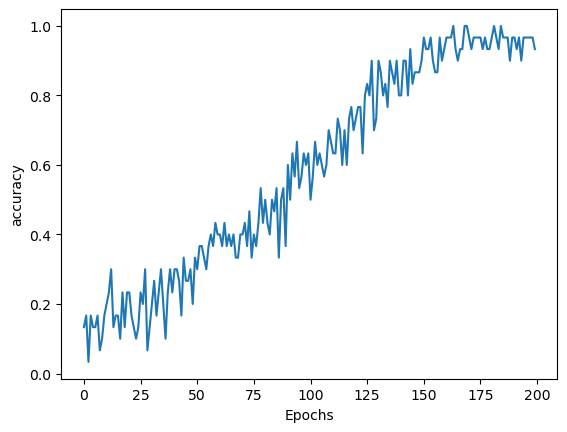

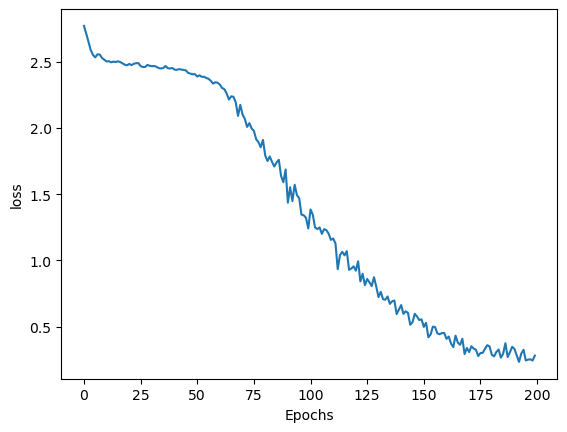

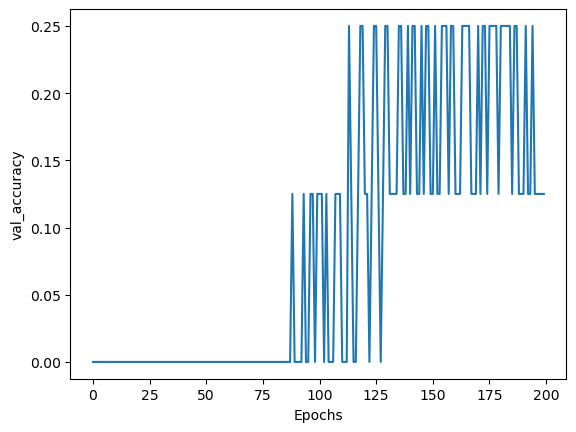

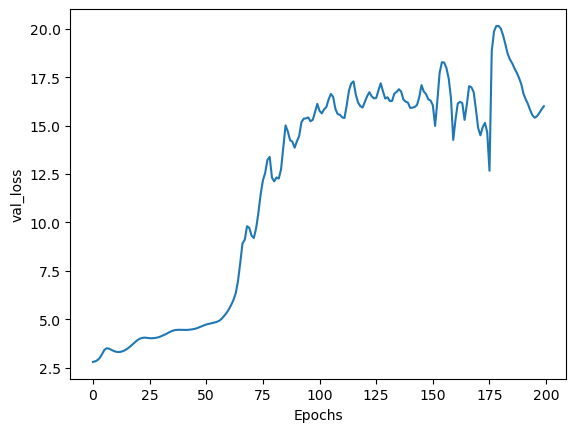

In [10]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "val_accuracy")
plot_graphs(history, "val_loss")

In [ ]:
try:
    user_input = input('Masukkan pertanyaan: ')
    user_input = ''.join([letters.lower() for letters in user_input if letters not in string.punctuation])
    texts_p = [user_input]
    
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = pad_sequences(prediction_input, maxlen=input_shape)
    
    predicted_output = model.predict(prediction_input)
    predicted_label_index = np.argmax(predicted_output)
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]
    
    print('Chatbot:', predicted_label)
except:
    print("Chatbot: Maaf, saya tidak memahami maksud Anda.")

1/1 [==============================] - 1s 1s/step
Chatbot: PMS (Sindrom Pra-Menstruasi)


In [11]:
import random

while True:
    user_input = input('You: ')
    if user_input.lower() == 'goodbye':
        print("Chatbot: Goodbye!")
        break
    try:
        input_seq = tokenizer.texts_to_sequences([user_input])
        input_seq = pad_sequences(input_seq, maxlen=input_shape)
        predicted_label_seq = model.predict(input_seq)
        predicted_label = label_encoder.inverse_transform([predicted_label_seq.argmax(axis=-1)])[0]
        print("tags:", predicted_label)

        # Pilih respons dari kategori tag
        responses_for_tag = responses.get(predicted_label, ["Chatbot: Maaf, saya tidak memahami maksud Anda."])
        response = random.choice(responses_for_tag)
        
        print("Chatbot:", response)
    except:
        print("Chatbot: Maaf, saya tidak memahami maksud Anda.")


1/1 [==============================] - 0s 443ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: greetings.whatareyoudoing
Chatbot: Menunggu balasan dari kamu
1/1 [==============================] - 0s 27ms/step


c:\Users\nurul\anaconda3\envs\cnn\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: greetings.bye
Chatbot: Sampai nanti


In [8]:
def predict_answer(model, tokenizer, label_encoder, question):
    question = ''.join([letters.lower() for letters in question if letters not in string.punctuation])
    texts_p = [question]
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)
    output = model.predict(prediction_input)
    output = output.argmax()
    response_tag = label_encoder.inverse_transform([output])[0]
    return response_tag

In [9]:
import random
while True:
    
    user_input = input('You: ')
    if user_input.lower() == 'goodbye':
        print("Chatbot: Goodbye!")
        break

    # Use your predict_answer function to get the response
    response_tag = predict_answer(model, tokenizer, label_encoder, user_input)

    print("Chatbot:", random.choice(responses.get(response_tag, ["I'm sorry, I don't understand that."])))

1/1 [==============================] - 0s 325ms/step
Chatbot: Menstruasi adalah proses alami yang terjadi pada wanita setiap bulan. Selama menstruasi, tubuh melepaskan lapisan rahim yang tidak diperlukan melalui vagina.
1/1 [==============================] - 0s 17ms/step
Chatbot: Menstruasi adalah proses alami yang terjadi pada wanita setiap bulan. Selama menstruasi, tubuh melepaskan lapisan rahim yang tidak diperlukan melalui vagina.
1/1 [==============================] - 0s 16ms/step
Chatbot: Menstrual cup adalah alat penampung darah menstruasi yang dapat digunakan berulang kali. Berikut adalah panduan penggunaan menstrual cup: 

1. Cuci tangan dengan sabun dan air mengalir. 
2. Oleskan air atau pelumas berbahan dasar air ke tepi gelas. 
3. Lipat dengan kuat cangkir menstruasi menjadi dua, pegang di satu tangan dengan tepi menghadap ke atas. 
4. Masukkan cangkir, pelek ke atas, ke dalam vagina seperti Anda akan memasukkan tampon tanpa aplikator. 
5. Setelah cangkir berada di dalam va